In [37]:
from state import State
from county import County

In [38]:
California = State('CO','/Users/nadiiapoliakovska/Documents/Air_Pollution (Justin)')
California_df = California.create_df()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [20]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt 
import logging
import matplotlib.dates as mdates
   
PATH_TO_DATA = r'/Users/nadiiapoliakovska/Documents/Air_Pollution (Justin)'
PM25_pattern = r'Cal_PM2.5*.csv'
CO_pattern = r'Cal_CO*.csv'
EPA_O_3_pattern = r'EPA_O_3.csv'
    
class State:

    def __init__(self, path_to_folder, pattern):
        self.path_to_folder = path_to_folder
        self.pattern = pattern
    
    def create_df(self): 
        '''path_to_folder can be assigned to PATH_TO_DATA
        pattern for California is
        r'Cal_PM2.5*.csv' or
        r'Cal_CO*.csv' or
        r'EPA_O_3.csv' '''
        logging.basicConfig(level=logging.ERROR)
        files = glob.glob(os.path.join(self.path_to_folder, self.pattern))
        if len(files) > 1:
            df_list = []
            for i in files:
                df = pd.read_csv(i)
                df_list.append(df)
            big_df = pd.concat(df_list, ignore_index = True)
        elif len(files) == 1:
            big_df = pd.read_csv(files[0])
        else:
            big_df = "No files in the folder with this pattern"
        return big_df 
    
    def county_names(self):
        df = State(self.path_to_folder, self.pattern).create_df()
        return df['COUNTY'].unique()

In [21]:
class County(State):
    def __init__(self, path_to_folder, pattern, county): #county shoud be string
        super().__init__(path_to_folder, pattern)
        self.county = county
        
    def sub_df(self): 
        logging.basicConfig(level=logging.ERROR)
        df = super().create_df()
        if self.county in df['COUNTY'].unique():
            county_df = df.loc[df['COUNTY'] == self.county]
            county_df.loc[:,'Date'] = county_df.loc[:, 'Date'].apply(pd.to_datetime)
            county_df = county_df.sort_values(by=['Date'])
            ind = np.arange(0, len(county_df))
            county_df.set_index(ind, inplace = True)
        else: 
            print("No such county in this dataframe")
        return county_df
    
    def diff_values(self):
        logging.basicConfig(level=logging.ERROR)
        df = self.sub_df()
        l =[]
        for i in df.columns:
            if len(df[i].unique())!=1 :
                l.append(i)
        return l
    
    def sub_df_unique(self):
        df = self.sub_df()
        df_unique = df[['Date', 'Daily Mean PM2.5 Concentration', 'Site Name', 'SITE_LATITUDE', 'SITE_LONGITUDE']]
        df_unique.rename(columns={"Daily Mean PM2.5 Concentration": "Daily Mean PM2.5 Concentration, ug/m3 LC"},
                 inplace = True)
        df_unique = df_unique.groupby(by= ["Date", "Site Name"], as_index = False).mean()
        df_unique['Month'] = pd.DatetimeIndex(df_unique['Date']).month
        df_unique['Year_Month'] = pd.DatetimeIndex(df_unique['Date']).to_period('M')
        df_unique['Year'] = pd.DatetimeIndex(df_unique['Date']).year
        return df_unique
    
    def preprocessed(self):
        logging.basicConfig(level=logging.ERROR)
        county_df_unique = self.sub_df()
           
        #county_df_unique = county_df[self.diff_values()]    
            
        if (county_df_unique['UNITS'].unique() != 'ug/m3 LC').any() or (len(county_df_unique['UNITS'].unique())==2):
            county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']
            county_df_unique['UNITS'] = county_df_unique['UNITS'].replace('ppm', 'ug/m3 LC')
        county_df_unique.rename(columns={"Daily Mean PM2.5 Concentration": "Daily Mean PM2.5 Concentration, ug/m3 LC"},
                 inplace = True)
        
        if county_df_unique['Site Name'].isna().unique().all():
            county_df_unique == county_df_unique
        elif "Site Name" in county_df_unique.columns:
            county_df_unique = county_df_unique.groupby(by= ["Date", "Site Name"], as_index = False).mean()
        elif "COUNTY" in county_df_unique.columns:
            county_df_unique = county_df_unique.groupby(by= ["Date", "COUNTY"], as_index = False).mean()
        else:
            print('No COUNTY or Site Name in columns name of the ' + self.county + ' dataframe')
            for j in ["Site Name", "County"]:
                if j in county_df.columns:
                    county_df_unique = county_df_unique.join(county_df[j])
                    print("Joined " + j + " to " + self.county + '  unique dataframe')
                    county_df_unique = county_df_unique.groupby(by= ["Date", j], as_index = False).mean()
                else:
                    print("No " + j +" in "+ self.county + ' dataframe')
        
        county_df_unique['Month'] = pd.DatetimeIndex(county_df_unique['Date']).month
        county_df_unique['Year_Month'] = pd.DatetimeIndex(county_df_unique['Date']).to_period('M')
        county_df_unique['Year'] = pd.DatetimeIndex(county_df_unique['Date']).year

        return county_df_unique
    
    def county_plot_Daily_PM25(self):
        logging.basicConfig(level=logging.ERROR)
        df = self.preprocessed()
        %matplotlib inline
        plt.figure(figsize = (16, 10))
        x = df['Date']
        y = df['Daily Mean PM2.5 Concentration, ug/m3 LC']
        
            
        plt.stem(x, y, markerfmt=' ', basefmt=' ')  # No baseline for stems         
        # Beautify the x-axis by formatting dates
        #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())         
        plt.xlabel('Date', fontsize=20)
        plt.ylabel('Daily Mean PM2.5 Concentration, ug/m³ LC', fontsize=20)
        plt.title("Daily PM2.5 concentration changes with years for " + self.county + " county", fontsize=20)
        plt.grid()
        # Increase the font size of x and y ticks
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        #California = super().create_df()
        #plt.xlim(pd.to_datetime(California["Date"].min(), format = '%m/%d/%Y'),
        #     pd.to_datetime(California["Date"].max(), format = '%m/%d/%Y'))
        #plt.ylim(California["Daily Mean PM2.5 Concentration"].min(), California["Daily Mean PM2.5 Concentration"].max())
        plt.savefig("Air_Pollution_plots/Daily PM2.5 concentration changes with years/Daily PM2.5 concentration changes with years for " + self.county + " county.pdf", format="pdf", bbox_inches="tight")
        # Show the plot
        plt.tight_layout()
        plt.show()

In [22]:
California = State(PATH_TO_DATA, CO_pattern)
California_df = California.create_df()

In [23]:
California_df

,Date,Source,Site ID,POC,Daily Max 8-hour CO Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,1/1/2019,AQS,60010009,1,0.4,ppm,5,Oakland,18,75,42101,Carbon monoxide,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.743065,-122.169935
1,1/2/2019,AQS,60010009,1,0.6,ppm,7,Oakland,24,100,42101,Carbon monoxide,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.743065,-122.169935
2,1/3/2019,AQS,60010009,1,0.6,ppm,7,Oakland,24,100,42101,Carbon monoxide,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.743065,-122.169935
3,1/4/2019,AQS,60010009,1,0.7,ppm,8,Oakland,24,100,42101,Carbon monoxide,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.743065,-122.169935
4,1/5/2019,AQS,60010009,1,0.6,ppm,7,Oakland,24,100,42101,Carbon monoxide,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.743065,-122.169935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292775,12/27/2016,AQS,61010004,3,0.1,ppm,1,Sutter Buttes (seasonal),24,100,42101,Carbon monoxide,49700,"Yuba City, CA",6,California,101,Sutter,39.205572,-121.820362
292776,12/28/2016,AQS,61010004,3,0.1,ppm,1,Sutter Buttes (seasonal),24,100,42101,Carbon monoxide,49700,"Yuba City, CA",6,California,101,Sutter,39.205572,-121.820362
292777,12/29/2016,AQS,61010004,3,0.1,ppm,1,Sutter Buttes (seasonal),24,100,42101,Carbon monoxide,49700,"Yuba City, CA",6,California,101,Sutter,39.205572,-121.820362
292778,12/30/2016,AQS,61010004,3,0.3,ppm,3,Sutter Buttes (seasonal),24,100,42101,Carbon monoxide,49700,"Yuba City, CA",6,California,101,Sutter,39.205572,-121.820362


In [24]:
California_df.describe()

,Site ID,POC,Daily Max 8-hour CO Concentration,DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,CBSA_CODE,STATE_CODE,COUNTY_CODE,SITE_LATITUDE,SITE_LONGITUDE
count,2.927800e+05,292780.000000,292780.000000,292780.000000,292780.000000,292780.000000,292780.0,292780.000000,292780.0,292780.000000,292780.000000,292780.000000
mean,6.051635e+07,1.390570,0.463089,5.241868,23.270787,96.973318,42101.0,35513.061070,6.0,51.456336,35.683476,-119.552582
std,2.660723e+05,1.306401,0.344152,4.001227,2.573630,10.701569,0.0,7850.562285,0.0,26.590204,2.086406,2.131272
min,6.001001e+07,1.000000,-0.500000,0.000000,1.000000,4.000000,42101.0,12540.000000,6.0,1.000000,32.552164,-124.201390
25%,6.037002e+07,1.000000,0.200000,2.000000,24.000000,100.000000,42101.0,31080.000000,6.0,37.000000,34.010290,-121.641918
50%,6.059001e+07,1.000000,0.400000,5.000000,24.000000,100.000000,42101.0,40140.000000,6.0,59.000000,34.595900,-118.788630
75%,6.071900e+07,1.000000,0.600000,7.000000,24.000000,100.000000,42101.0,41860.000000,6.0,71.000000,37.765946,-117.751400
max,6.101000e+07,9.000000,12.800000,156.000000,24.000000,100.000000,42101.0,49700.000000,6.0,101.000000,40.776780,-115.390544


In [25]:
California_df.dtypes

Date                                  object
Source                                object
Site ID                                int64
POC                                    int64
Daily Max 8-hour CO Concentration    float64
UNITS                                 object
DAILY_AQI_VALUE                        int64
Site Name                             object
DAILY_OBS_COUNT                        int64
PERCENT_COMPLETE                       int64
AQS_PARAMETER_CODE                     int64
AQS_PARAMETER_DESC                    object
CBSA_CODE                              int64
CBSA_NAME                             object
STATE_CODE                             int64
STATE                                 object
COUNTY_CODE                            int64
COUNTY                                object
SITE_LATITUDE                        float64
SITE_LONGITUDE                       float64
dtype: object

In [26]:
California_df.loc[:,'Date'] = California_df.loc[:, 'Date'].apply(pd.to_datetime)
California_df['Month'] = pd.DatetimeIndex(California_df['Date']).month
California_df['Year_Month'] = pd.DatetimeIndex(California_df['Date']).to_period('M')
California_df['Year'] = pd.DatetimeIndex(California_df['Date']).year

In [33]:
#Select data for the wet season
wet_df = California_df.loc[California_df['Month'].isin([1,2,3,11,12])]
wet_df

,Date,Source,Site ID,POC,Daily Max 8-hour CO Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,...,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE,Month,Year_Month,Year
0,2019-01-01 00:00:00,AQS,60010009,1,0.4,ppm,5,Oakland,18,75,...,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.743065,-122.169935,1,2019-01,2019
1,2019-01-02 00:00:00,AQS,60010009,1,0.6,ppm,7,Oakland,24,100,...,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.743065,-122.169935,1,2019-01,2019
2,2019-01-03 00:00:00,AQS,60010009,1,0.6,ppm,7,Oakland,24,100,...,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.743065,-122.169935,1,2019-01,2019
3,2019-01-04 00:00:00,AQS,60010009,1,0.7,ppm,8,Oakland,24,100,...,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.743065,-122.169935,1,2019-01,2019
4,2019-01-05 00:00:00,AQS,60010009,1,0.6,ppm,7,Oakland,24,100,...,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.743065,-122.169935,1,2019-01,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292775,2016-12-27 00:00:00,AQS,61010004,3,0.1,ppm,1,Sutter Buttes (seasonal),24,100,...,"Yuba City, CA",6,California,101,Sutter,39.205572,-121.820362,12,2016-12,2016
292776,2016-12-28 00:00:00,AQS,61010004,3,0.1,ppm,1,Sutter Buttes (seasonal),24,100,...,"Yuba City, CA",6,California,101,Sutter,39.205572,-121.820362,12,2016-12,2016
292777,2016-12-29 00:00:00,AQS,61010004,3,0.1,ppm,1,Sutter Buttes (seasonal),24,100,...,"Yuba City, CA",6,California,101,Sutter,39.205572,-121.820362,12,2016-12,2016
292778,2016-12-30 00:00:00,AQS,61010004,3,0.3,ppm,3,Sutter Buttes (seasonal),24,100,...,"Yuba City, CA",6,California,101,Sutter,39.205572,-121.820362,12,2016-12,2016


In [34]:
#Calculate the mean CO value for wet season
mean_wet = wet_df['Daily Max 8-hour CO Concentration'].mean()
mean_wet

0.615470131923514

In [45]:
"""
https://www.co2meter.com/blogs/news/carbon-monoxide-levels-chart
The World Health Organization WHO suggests maximum carbon monoxide levels both in response to their mandate for 
outdoor clean air and to help countries develop indoor air quality building standards. In indoor environments, 
space heaters fueled with oil, gas or kerosene, gas stoves, combustion appliances and tobacco smoking are known to 
cause significant emissions of carbon monoxide. The WHO recommended limits are:

9-10 ppm for no more than 8 hours
25-35 ppm for no more than 1 hour
90-100 ppm for no more than 15 minutes
"""
healthy = 9 #9 ppm (parts-per-million) is the maximum indoor safe carbon monoxide level over 8 hours
unhealthy = 35 #Can cause issues for people with existing breathing issues such as asthma
danger = 100 #200 ppm or greater will cause physical symptoms and is fatal in hours

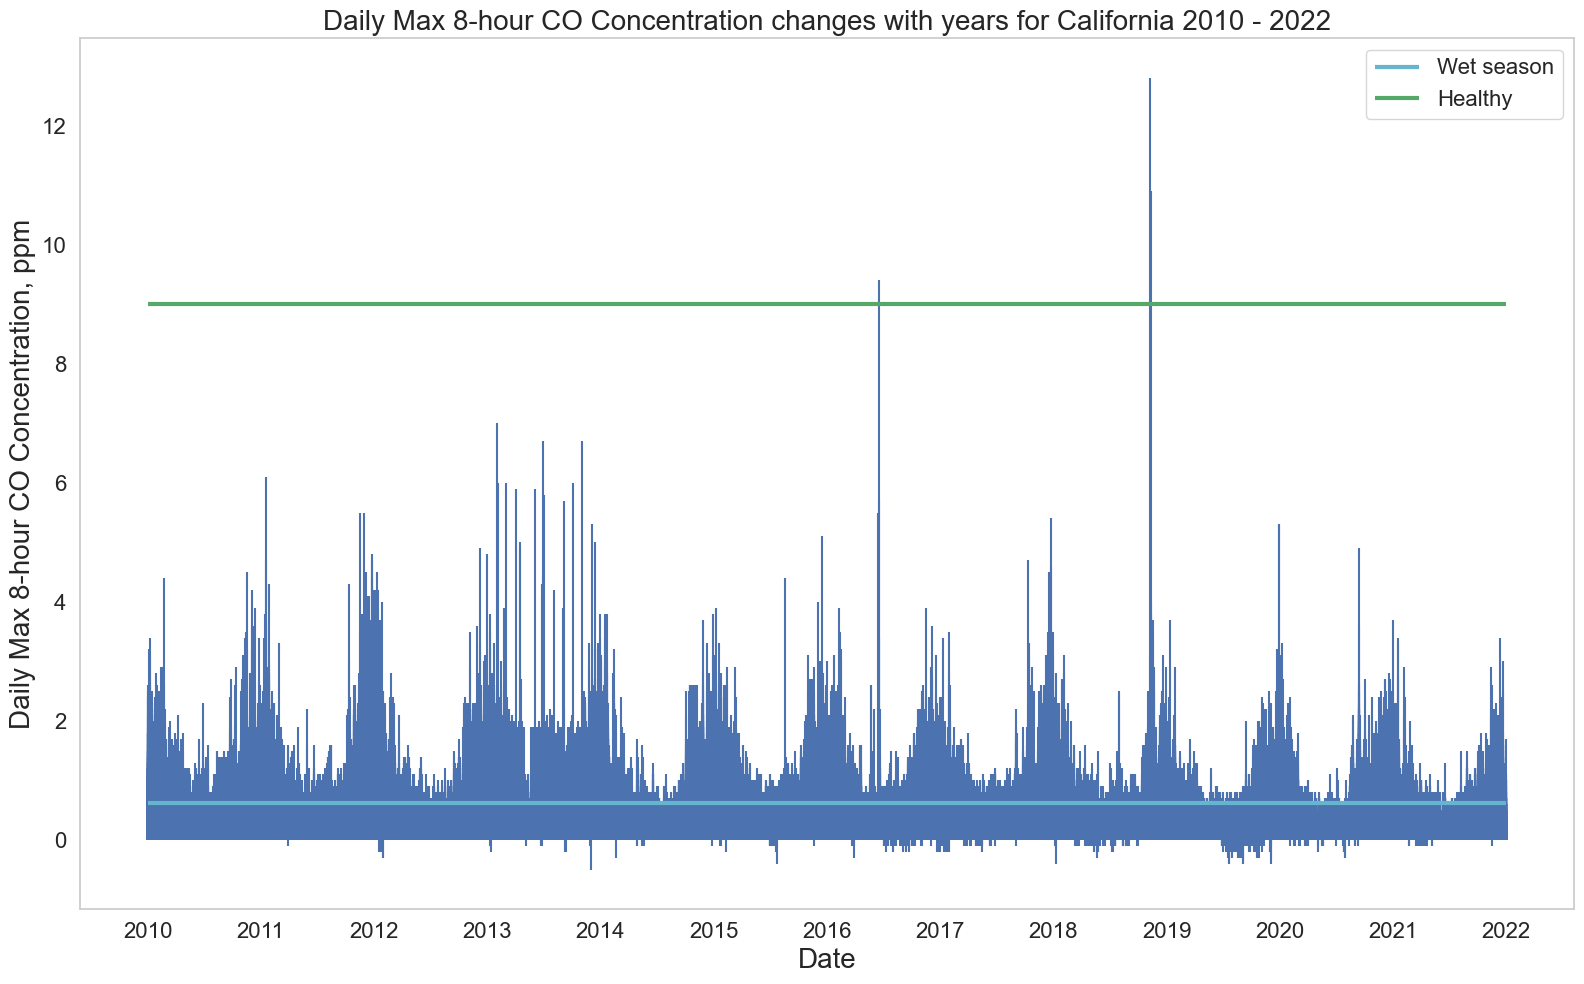

In [47]:
from matplotlib.dates import date2num

plt.figure(figsize = (16, 10))
x = California_df['Date']
y = California_df['Daily Max 8-hour CO Concentration']
        
plt.stem(x, y, markerfmt=' ', basefmt=' ')  # No baseline for stems 
plt.hlines(y=mean_wet, xmin=date2num(wet_df['Date'].min()), xmax=date2num(wet_df['Date'].max()),
           label = 'Wet season', linewidth=3, color='c')# Horizontal line for the wet value
plt.hlines(y=healthy, xmin=date2num(wet_df['Date'].min()), xmax=date2num(wet_df['Date'].max()),
           label = 'Healthy', linewidth=3, color='g')# Horizontal line for the healthy value
#plt.hlines(y=unhealthy, xmin=date2num(wet_df['Date'].min()), xmax=date2num(wet_df['Date'].max()),
           #label = 'Unhealthy', linewidth=3, color='y')# Horizontal line for the unhealthy value
#plt.hlines(y=danger, xmin=date2num(wet_df['Date'].min()), xmax=date2num(wet_df['Date'].max()),
#           label = 'Danger', linewidth=3, color='r')# Horizontal line for the danger value

plt.gca().xaxis.set_major_locator(mdates.YearLocator())         
plt.xlabel('Date', fontsize=20)
plt.ylabel('Daily Max 8-hour CO Concentration, ppm', fontsize=20)
plt.title("Daily Max 8-hour CO Concentration changes with years for California 2010 - 2022", fontsize=20)
plt.grid()
# Increase the font size of x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize = 16)
plt.savefig("Presentation/Daily Max 8-hour CO Concentration changes with years for California.pdf", format="pdf", bbox_inches="tight")
# Show the plot
plt.tight_layout()
plt.show()

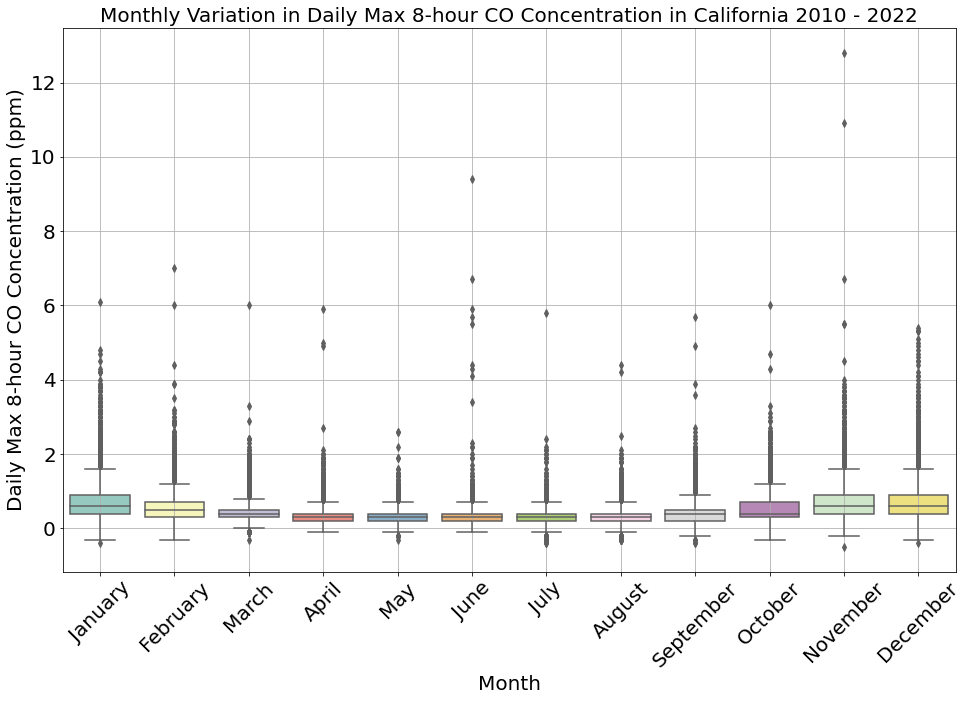

In [58]:
import seaborn as sns
import calendar
plt.figure(figsize=(16, 10))
sns.boxplot(x='Month', y='Daily Max 8-hour CO Concentration', data=California_df, palette='Set3')
plt.title('Monthly Variation in Daily Max 8-hour CO Concentration in California 2010 - 2022', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Daily Max 8-hour CO Concentration (ppm)', fontsize=20)
plt.grid()

plt.xticks(np.arange(0, 12), calendar.month_name[1:], rotation=45, fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("Presentation/Boxplot - Monthly Variation in Daily Max 8-hour CO Concentration for California.pdf", format="pdf", bbox_inches="tight")
plt.show()

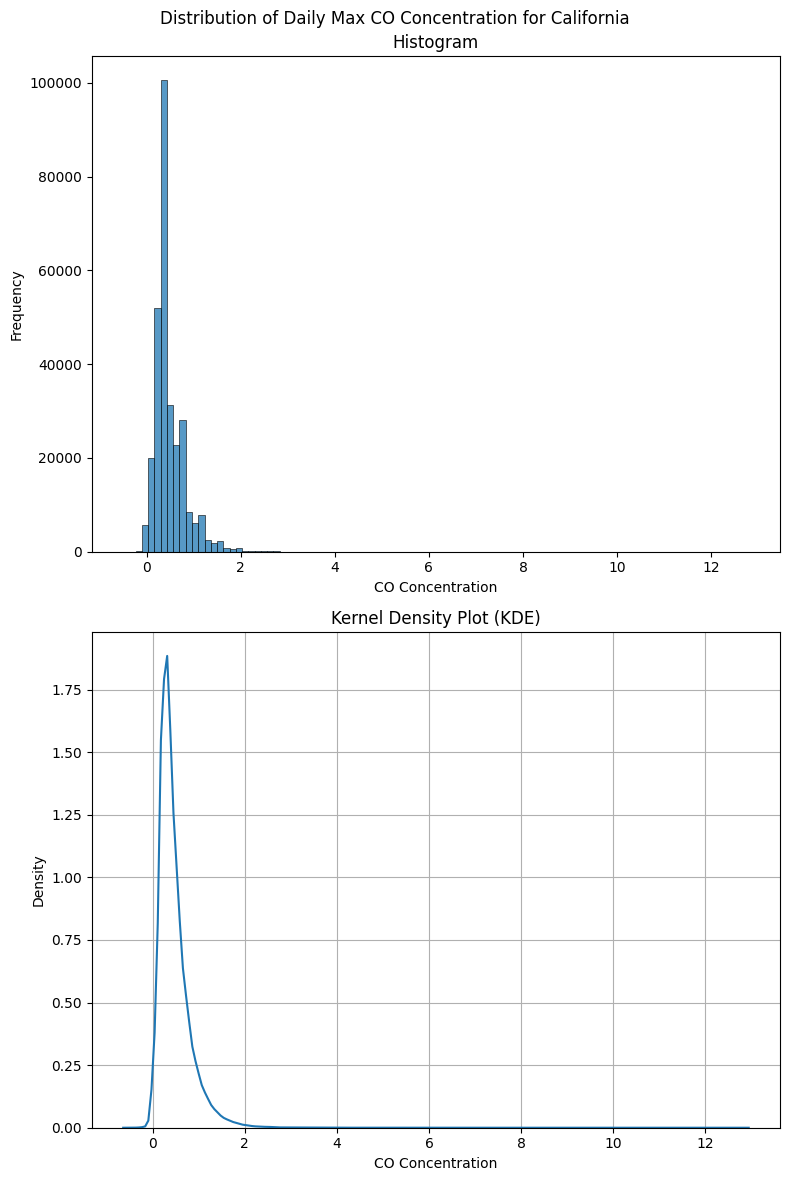

In [12]:
# Create subplots with histograms and KDE plots

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Histogram
sns.histplot(California_df['Daily Max 8-hour CO Concentration'], bins=100, kde=False, ax=axes[0])
axes[0].set_title('Histogram')
axes[0].set_xlabel('CO Concentration')
axes[0].set_ylabel('Frequency')

# KDE Plot
sns.kdeplot(California_df['Daily Max 8-hour CO Concentration'], ax=axes[1], bw_adjust = 1.7)
axes[1].set_title('Kernel Density Plot (KDE)')
axes[1].set_xlabel('CO Concentration')
axes[1].set_ylabel('Density')

# Add a title for the entire plot
plt.suptitle('Distribution of Daily Max CO Concentration for California')

# Show the plots
plt.tight_layout()
plt.grid()

plt.savefig("Presentation/Histogram - Distribution of Daily Max CO Concentration for California.pdf", format="pdf", bbox_inches="tight")
plt.show()

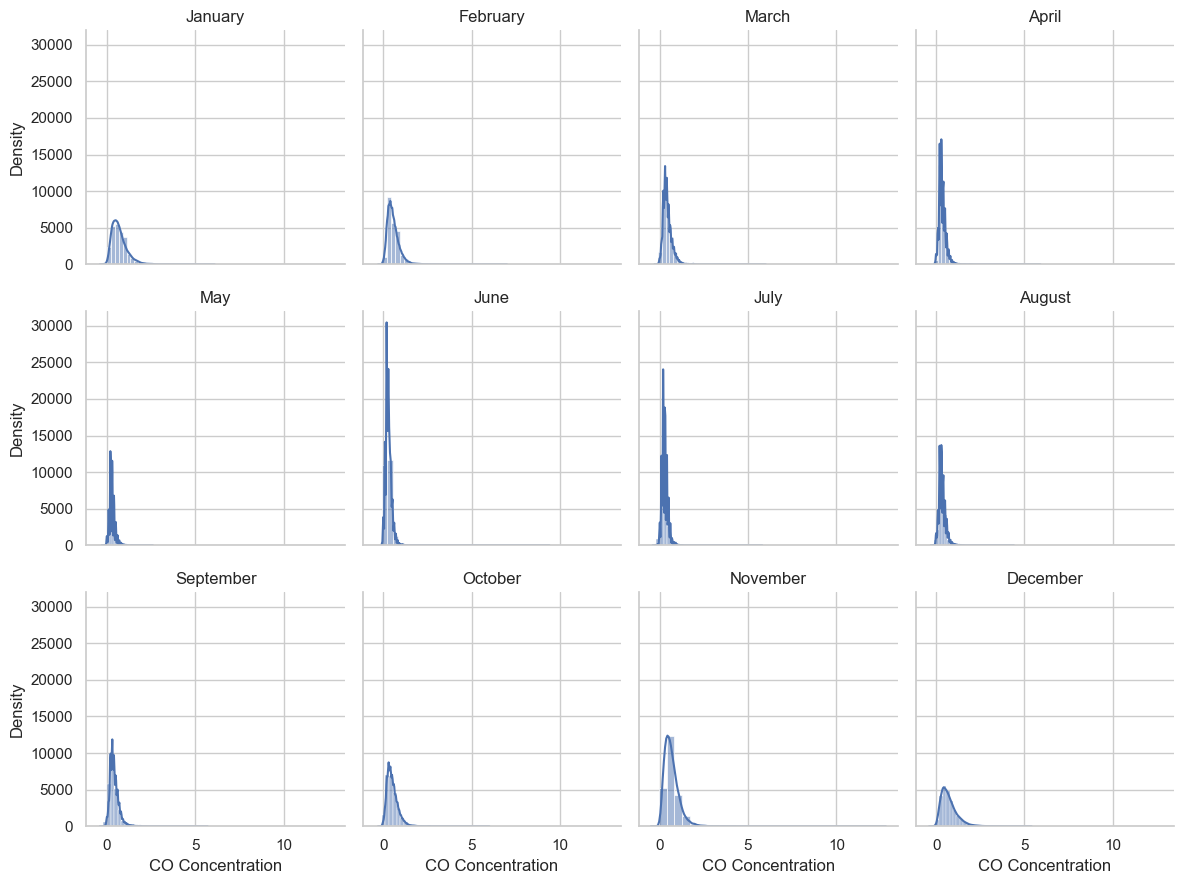

In [30]:
# Create subplots for each month
%matplotlib inline
import seaborn as sns
g = sns.FacetGrid(California_df, col="Month", col_wrap=4, height=3, margin_titles=True)
g.map_dataframe(sns.histplot, x="Daily Max 8-hour CO Concentration", bins=30, kde=True)
g.set_axis_labels("CO Concentration", "Density")

# Add titles for each subplot
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
for ax, month in zip(g.axes.flat, range(1, 13)):
    ax.set_title(months[month])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

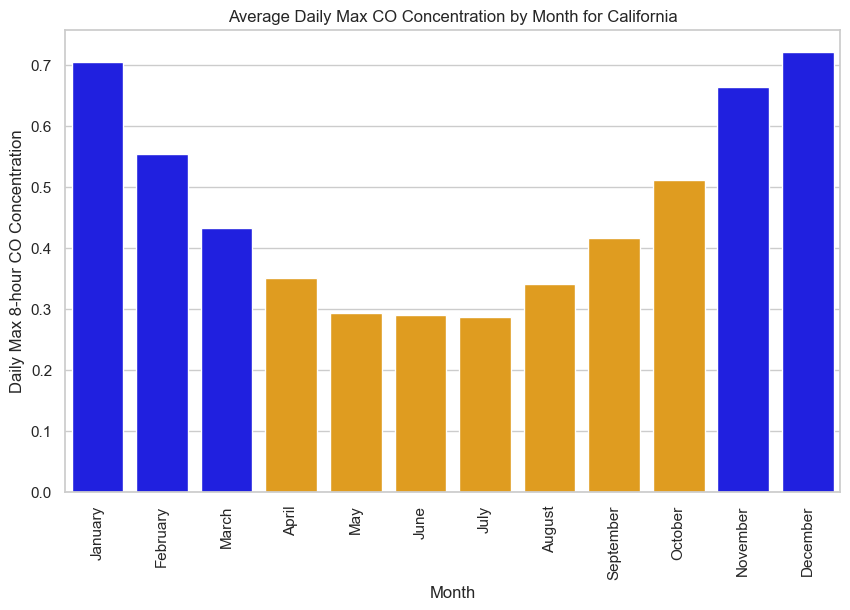

In [53]:
# Calculate the average PM2.5 concentration for each month
average_pm25_by_month = California_df.groupby('Month')['Daily Max 8-hour CO Concentration'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
clrs = ['orange' if (3 < x < 11) else 'blue' for x in average_pm25_by_month.Month ]
sns.barplot(data=average_pm25_by_month, x='Month', y='Daily Max 8-hour CO Concentration', palette=clrs)

# Customize the plot
plt.title('Average Daily Max CO Concentration by Month for California')
plt.xlabel('Month')
plt.ylabel('Daily Max 8-hour CO Concentration')
plt.xticks(range(12), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
                        'October', 'November', 'December'], rotation=90)

plt.savefig("Presentation/Barplot - Average Daily Max CO Concentration by Month for California.pdf", format="pdf", bbox_inches="tight")
plt.show()

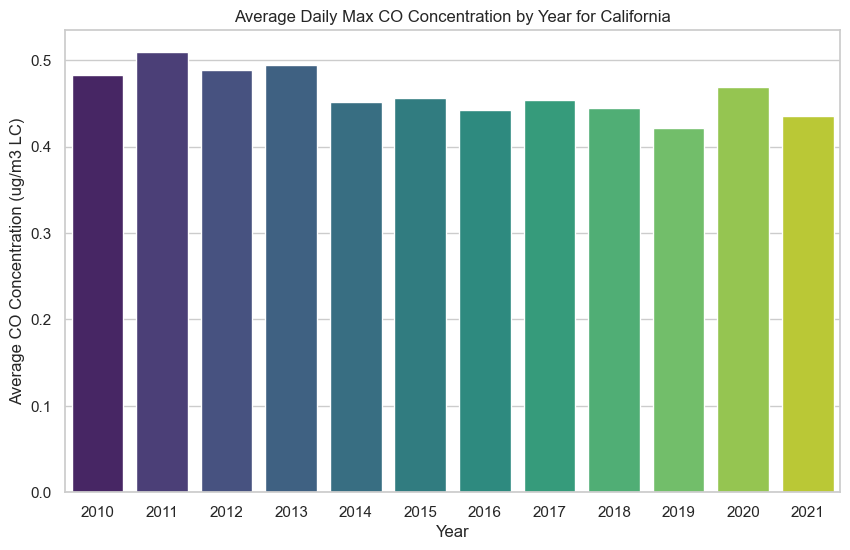

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average PM2.5 concentration for each year
average_pm25_by_year = California_df.groupby('Year')['Daily Max 8-hour CO Concentration'].mean().reset_index()

# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=average_pm25_by_year, x='Year', y='Daily Max 8-hour CO Concentration', palette='viridis')

# Customize the plot
plt.title('Average Daily Max CO Concentration by Year for California')
plt.xlabel('Year')
plt.ylabel('Average CO Concentration (ug/m3 LC)')

# Set x ticks for every year
#plt.xticks(rotation=45)

plt.savefig("Presentation/Barplot - Average Daily Max CO Concentration by Year for California.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [48]:
#Selecting data for 2010 - 2019 years to add to the folium map to compare with wildfires
print(California_df.Date.max())
print(California_df.Date.min())

2021-12-31 00:00:00
2010-01-01 00:00:00


In [49]:
California_df_1019 = California_df[California_df.Year <=2019]
California_1019_grouped = California_df_1019[['Year', 'COUNTY', 'Daily Max 8-hour CO Concentration']].groupby(['COUNTY', 'Year'], as_index=False).max()
California_1019_county_CO = California_1019_grouped[['COUNTY', 	'Daily Max 8-hour CO Concentration']].groupby('COUNTY', as_index = False).mean()
California_1019_county_CO

,COUNTY,Daily Max 8-hour CO Concentration
0,Alameda,2.440000
1,Butte,2.730000
2,Contra Costa,1.240000
3,Fresno,2.100000
4,Humboldt,1.100000
5,Imperial,4.500000
6,Inyo,0.725000
7,Kern,1.144444
8,Los Angeles,3.810000
9,Madera,1.740000


In [50]:
from pathlib import Path
filepath = Path('California_1019_county_CO.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
California_1019_county_CO.to_csv(filepath)